In [2]:
import sys
sys.path.append("../code")
import numpy as np

from attention_utils import get_activations, get_data

np.random.seed(1337)  # for reproducibility
from keras.models import *
from keras.layers import Input, Dense, merge

input_dim = 32


def build_model():
    inputs = Input(shape=(input_dim,))

    # ATTENTION PART STARTS HERE
    attention_probs = Dense(input_dim, activation='softmax', name='attention_vec')(inputs)
    attention_mul = merge([inputs, attention_probs], output_shape=32, name='attention_mul', mode='mul')
    # ATTENTION PART FINISHES HERE

    attention_mul = Dense(64)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


Using TensorFlow backend.
/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
N = 10000
inputs_1, outputs = get_data(N, input_dim)

m = build_model()
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

m.fit([inputs_1], outputs, epochs=20, batch_size=64, validation_split=0.5)

testing_inputs_1, testing_outputs = get_data(1, input_dim)

# Attention vector corresponds to the second matrix.
# The first one is the Inputs output.
attention_vector = get_activations(m, testing_inputs_1,
                                   print_shape_only=True,
                                   layer_name='attention_vec')[0].flatten()
print('attention =', attention_vector)

# plot part.
import matplotlib.pyplot as plt
import pandas as pd

/Users/nipun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/nipun/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/nipun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 32)           1056        input_1[0][0]                    
__________________________________________________________________________________________________
attention_mul (Merge)           (None, 32)           0           input_1[0][0]                    
                                                                 attention_vec[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        attention_mul[0][0]              
__________

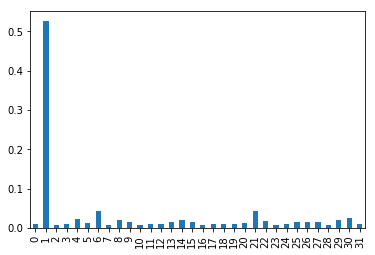

In [8]:
%matplotlib inline
pd.Series(attention_vector).plot(kind='bar')

In [9]:
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

from attention_utils import get_activations, get_data_recurrent

INPUT_DIM = 2
TIME_STEPS = 20
# if True, the attention vector is shared across the input_dimensions where the attention is applied.
SINGLE_ATTENTION_VECTOR = False
APPLY_ATTENTION_BEFORE_LSTM = False


def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul


def model_attention_applied_after_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    lstm_units = 32
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


def model_attention_applied_before_lstm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIM,))
    attention_mul = attention_3d_block(inputs)
    lstm_units = 32
    attention_mul = LSTM(lstm_units, return_sequences=False)(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(input=[inputs], output=output)
    return model


In [10]:
N = 300000
# N = 300 -> too few = no training
inputs_1, outputs = get_data_recurrent(N, TIME_STEPS, INPUT_DIM)

if APPLY_ATTENTION_BEFORE_LSTM:
    m = model_attention_applied_before_lstm()
else:
    m = model_attention_applied_after_lstm()

m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(m.summary())

m.fit([inputs_1], outputs, epochs=1, batch_size=64, validation_split=0.1)

attention_vectors = []

/Users/nipun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/nipun/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/nipun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 2)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 20, 32)       4480        input_2[0][0]                    
__________________________________________________________________________________________________
permute_1 (Permute)             (None, 32, 20)       0           lstm_1[0][0]                     
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 32, 20)       0           permute_1[0][0]                  
__________________________________________________________________________________________________
dense_3 (D

----- activations -----
(1, 20, 32)
attention = [ 0.00219333  0.00232133  0.00242945  0.00309207  0.0023527   0.00298569
  0.00257227  0.00225874  0.00228695  0.0035669   0.59385484  0.00524928
  0.35540175  0.00301347  0.00290094  0.00281188  0.00294731  0.00208525
  0.00285069  0.00282516]
----- activations -----
(1, 20, 32)
attention = [ 0.00115312  0.00143374  0.00188214  0.00144839  0.00165808  0.00145347
  0.00124488  0.0010887   0.00141622  0.00248096  0.58267438  0.00310863
  0.38659108  0.00271614  0.00215945  0.00177226  0.00149431  0.00149383
  0.00124745  0.00148275]
----- activations -----
(1, 20, 32)
attention = [ 0.00232666  0.00229853  0.00297646  0.00275319  0.00221134  0.00232335
  0.00197967  0.00253047  0.00195957  0.003157    0.59138513  0.00446098
  0.36147904  0.00255452  0.0017961   0.00413846  0.0023488   0.00222059
  0.00238167  0.00271844]
----- activations -----
(1, 20, 32)
attention = [ 0.00237926  0.00248061  0.00259802  0.0027959   0.00250207  0.00245417


(1, 20, 32)
attention = [ 0.00156702  0.00181267  0.00257713  0.00180258  0.00222495  0.00187467
  0.00165384  0.00149288  0.00177654  0.00265113  0.58578777  0.00389145
  0.37631443  0.00307948  0.00250746  0.00206359  0.00142026  0.00169143
  0.00206401  0.00174673]
----- activations -----
(1, 20, 32)
attention = [ 0.00119897  0.00142774  0.00141895  0.00133402  0.00128046  0.00158428
  0.00147604  0.00116291  0.00157103  0.00173342  0.60391992  0.00260315
  0.36513823  0.00286238  0.00235015  0.00188309  0.00215279  0.00150703
  0.00149465  0.00190076]
----- activations -----
(1, 20, 32)
attention = [ 0.0021259   0.00224122  0.00231955  0.00258899  0.0024504   0.0022218
  0.00202949  0.00219152  0.00206992  0.00314404  0.59207404  0.0051355
  0.35991925  0.00411593  0.00295751  0.00356223  0.00175145  0.00206894
  0.00209185  0.00294052]
----- activations -----
(1, 20, 32)
attention = [ 0.00149915  0.00138543  0.00231119  0.00188873  0.00141097  0.00156089
  0.0020333   0.00099421  

(1, 20, 32)
attention = [ 0.00102901  0.00127366  0.00133221  0.00138786  0.00119129  0.00132548
  0.00114997  0.00106255  0.00130422  0.00216746  0.58723682  0.00256086
  0.38616639  0.00271796  0.00152152  0.00164225  0.00100265  0.00131999
  0.00115608  0.00145172]
----- activations -----
(1, 20, 32)
attention = [ 0.00238433  0.00217827  0.00287915  0.00285433  0.00237031  0.00264483
  0.00242446  0.00247507  0.00221392  0.00354886  0.58683825  0.00612582
  0.35946479  0.0039203   0.00311881  0.0032684   0.00266769  0.00233548
  0.00252944  0.00375745]
----- activations -----
(1, 20, 32)
attention = [ 0.00137892  0.00147749  0.00164033  0.00162648  0.00144607  0.00153132
  0.00149228  0.00140727  0.00154343  0.00245005  0.58707929  0.00331253
  0.3799071   0.00301339  0.00179496  0.00215519  0.00158166  0.00155979
  0.00159531  0.00200719]
----- activations -----
(1, 20, 32)
attention = [ 0.00223883  0.00261554  0.00272436  0.00284938  0.00290175  0.00240513
  0.00241719  0.00251512

(1, 20, 32)
attention = [ 0.00270217  0.00294768  0.0027399   0.0034881   0.00307639  0.00270676
  0.00336259  0.00273825  0.00247823  0.00700257  0.59218132  0.00616136
  0.34352398  0.0044417   0.00497705  0.00339111  0.00289473  0.00234104
  0.00301833  0.00382676]
----- activations -----
(1, 20, 32)
attention = [ 0.00136166  0.00123401  0.00163838  0.00157784  0.00133785  0.0014397
  0.00142983  0.00108263  0.0014408   0.00233746  0.59135091  0.00307088
  0.37967494  0.0025901   0.00158036  0.00160718  0.00113859  0.00125011
  0.00143658  0.00142017]
----- activations -----
(1, 20, 32)
attention = [ 0.00222223  0.00252331  0.00260697  0.00294367  0.00276916  0.00271115
  0.00232844  0.00275198  0.00266561  0.0036314   0.57852226  0.00674486
  0.36584851  0.00400746  0.00347085  0.00326884  0.00285937  0.00237027
  0.00250187  0.00325177]
----- activations -----
(1, 20, 32)
attention = [ 0.00163799  0.00144014  0.00205711  0.00182923  0.0015641   0.00167595
  0.00145507  0.00169183 

(1, 20, 32)
attention = [ 0.00074261  0.00077566  0.00093312  0.0009107   0.00074445  0.00081432
  0.00092957  0.00070436  0.0009562   0.00137311  0.59109879  0.00164378
  0.3909362   0.00184964  0.00099644  0.00115575  0.00076108  0.00081583
  0.0009491   0.00090932]
----- activations -----
(1, 20, 32)
attention = [ 0.00435309  0.00540638  0.0053431   0.00543641  0.00515877  0.00458143
  0.00420224  0.0049177   0.00493829  0.00741285  0.56132346  0.01022342
  0.3315078   0.00919963  0.00770862  0.00808623  0.00413797  0.00443122
  0.00511865  0.00651274]
----- activations -----
(1, 20, 32)
attention = [ 0.00103109  0.00109795  0.00117362  0.00103606  0.0011301   0.00104395
  0.0010366   0.00091401  0.00111594  0.00178745  0.58708674  0.00233422
  0.38884869  0.00284161  0.00135807  0.00168044  0.0008993   0.00126569
  0.00107307  0.00124537]
----- activations -----
(1, 20, 32)
attention = [ 0.000886    0.00092775  0.000988    0.0011267   0.00094911  0.00093631
  0.0009468   0.00087138

(1, 20, 32)
attention = [ 0.00250857  0.00223853  0.00274572  0.00266267  0.0026513   0.00212836
  0.0032165   0.00217662  0.00281198  0.00556351  0.58833164  0.00381717
  0.35706931  0.00387085  0.00252885  0.0032259   0.00367006  0.00299111
  0.00361158  0.00217968]
----- activations -----
(1, 20, 32)
attention = [ 0.00384204  0.0040386   0.00401564  0.00422875  0.0042713   0.00347463
  0.00412877  0.00444088  0.00393511  0.00649154  0.6078552   0.00737421
  0.30072725  0.00603082  0.00759074  0.00638397  0.00634457  0.00470809
  0.00460168  0.00551628]
----- activations -----
(1, 20, 32)
attention = [ 0.00098137  0.00119367  0.00128412  0.00112885  0.00111452  0.00106141
  0.00109259  0.0010084   0.00113223  0.0018221   0.5873723   0.00236491
  0.38838035  0.00251045  0.00138066  0.00170623  0.0008036   0.00112959
  0.0011877   0.0013449 ]
----- activations -----
(1, 20, 32)
attention = [ 0.00142604  0.00210508  0.00199881  0.00151972  0.00167107  0.00169674
  0.00173377  0.00140551

(1, 20, 32)
attention = [ 0.00276302  0.00281673  0.00270047  0.00359412  0.00326879  0.00294152
  0.00270004  0.00286051  0.00265691  0.00449538  0.59487921  0.00688561
  0.34390092  0.00416057  0.00396477  0.00370243  0.00268393  0.00279718
  0.00283517  0.00339271]
----- activations -----
(1, 20, 32)
attention = [ 0.00097887  0.00107529  0.00127606  0.001087    0.00103724  0.00118073
  0.00102105  0.000975    0.00125027  0.00155091  0.58899415  0.00225097
  0.3870734   0.00261323  0.00111305  0.00169917  0.00094843  0.00144315
  0.00108775  0.00134431]
----- activations -----
(1, 20, 32)
attention = [ 0.00104513  0.00130434  0.00121284  0.00117397  0.00123735  0.00103815
  0.00115748  0.00098714  0.00123375  0.0028101   0.58979779  0.00272787
  0.38319257  0.0029006   0.00186599  0.00155516  0.00103557  0.00120256
  0.00111287  0.00140874]
----- activations -----
(1, 20, 32)
attention = [ 0.00181156  0.00318275  0.00285217  0.00413354  0.00297381  0.00295867
  0.00364203  0.00192927

(1, 20, 32)
attention = [ 0.0020288   0.00179181  0.00233271  0.0022825   0.0020105   0.00203822
  0.00196898  0.00214084  0.00181487  0.00297706  0.58733052  0.0053373
  0.36731237  0.00352726  0.0030479   0.00282086  0.00217398  0.0019754
  0.00194366  0.00314444]
----- activations -----
(1, 20, 32)
attention = [ 0.00267012  0.0025512   0.00277964  0.00371064  0.00282707  0.00270431
  0.00262237  0.0028513   0.00279414  0.00476489  0.6209349   0.00600675
  0.31776124  0.00412531  0.00438625  0.00369855  0.00330945  0.00312849
  0.00270388  0.0036695 ]
----- activations -----
(1, 20, 32)
attention = [ 0.00083045  0.00112994  0.00128141  0.00116643  0.00102879  0.00107123
  0.00104816  0.00086106  0.00102277  0.00184006  0.59146345  0.0021705
  0.38684893  0.00206213  0.0011102   0.00133159  0.00068306  0.00088109
  0.00098878  0.00117999]
----- activations -----
(1, 20, 32)
attention = [ 0.00084719  0.00124721  0.00157331  0.00110391  0.00112654  0.00107211
  0.00145157  0.00093324  0

(1, 20, 32)
attention = [ 0.00092086  0.00094449  0.00114975  0.00099638  0.00097565  0.00095862
  0.00100131  0.00101322  0.00093316  0.00159418  0.59011328  0.00242623
  0.38858166  0.00202086  0.00111109  0.00129964  0.00076835  0.00093667
  0.00104709  0.00120751]
----- activations -----
(1, 20, 32)
attention = [ 0.0027125   0.00248846  0.00294208  0.00313798  0.00287065  0.0024663
  0.00274334  0.0028106   0.00291738  0.00520197  0.61534154  0.00580648
  0.3221381   0.00511927  0.00436138  0.00395529  0.00350809  0.00318612
  0.00284406  0.0034484 ]
----- activations -----
(1, 20, 32)
attention = [ 0.00164437  0.00227834  0.00203698  0.00227226  0.00192981  0.00194063
  0.00183852  0.00178382  0.00204032  0.00336605  0.58453172  0.00404156
  0.37439442  0.00342513  0.00228769  0.00261663  0.00157325  0.00194553
  0.00178569  0.00226729]
----- activations -----
(1, 20, 32)
attention = [ 0.0016381   0.00173251  0.00217135  0.00205244  0.00185526  0.00167945
  0.00160781  0.00171577 

(1, 20, 32)
attention = [ 0.00306125  0.0029072   0.00294602  0.00285358  0.00291434  0.00315231
  0.00273849  0.0031319   0.00295991  0.00374272  0.55996156  0.00630105
  0.37399283  0.00655523  0.00393993  0.00537071  0.00349421  0.00294522
  0.00318618  0.00384541]
----- activations -----
(1, 20, 32)
attention = [ 0.00263035  0.00321802  0.00329559  0.00346463  0.00295923  0.00263159
  0.00291833  0.00320472  0.00292833  0.00601404  0.59089172  0.00655991
  0.34167758  0.00479162  0.00536078  0.00415276  0.00295331  0.0029284
  0.00284271  0.00457635]
----- activations -----
(1, 20, 32)
attention = [ 0.00264458  0.00318946  0.00198837  0.00259117  0.0025861   0.00196514
  0.0035526   0.00277552  0.00294919  0.00932789  0.58334333  0.00411124
  0.34507209  0.0068889   0.0067317   0.00441687  0.00402999  0.0044233
  0.00352792  0.00388464]
----- activations -----
(1, 20, 32)
attention = [ 0.00184628  0.00218208  0.00241274  0.00198964  0.00206414  0.0020206
  0.00228094  0.00184319  0

(1, 20, 32)
attention = [ 0.00110648  0.00137988  0.00169128  0.00147088  0.00119741  0.00137704
  0.00137516  0.00126451  0.00153938  0.00232153  0.58456445  0.00251901
  0.38711542  0.00229221  0.00152751  0.00172388  0.00117083  0.00142368
  0.0014988   0.00144063]
----- activations -----
(1, 20, 32)
attention = [ 0.0046448   0.00476701  0.00485261  0.00548447  0.00505842  0.00423991
  0.00572851  0.00520082  0.00500895  0.01001274  0.59100628  0.00834141
  0.29603148  0.00797414  0.00848521  0.00702163  0.00796319  0.00564685
  0.00629024  0.00624128]
----- activations -----
(1, 20, 32)
attention = [ 0.00167441  0.00209399  0.00221691  0.00316809  0.00199304  0.00205218
  0.00284209  0.00181139  0.0020248   0.00491549  0.58702189  0.00398668
  0.36769864  0.00334809  0.00248717  0.00234705  0.00188716  0.00174188
  0.00238369  0.0023054 ]
----- activations -----
(1, 20, 32)
attention = [ 0.001092    0.00113721  0.00128595  0.0011641   0.00111725  0.00108447
  0.00112716  0.00103675

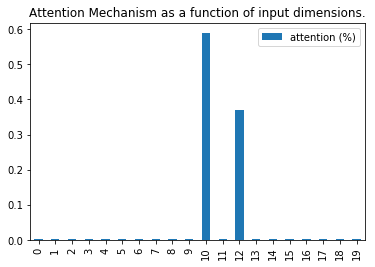

In [11]:
for i in range(300):
    testing_inputs_1, testing_outputs = get_data_recurrent(1, TIME_STEPS, INPUT_DIM)
    attention_vector = np.mean(get_activations(m,
                                               testing_inputs_1,
                                               print_shape_only=True,
                                               layer_name='attention_vec')[0], axis=2).squeeze()
    print('attention =', attention_vector)
    assert (np.sum(attention_vector) - 1.0) < 1e-5
    attention_vectors.append(attention_vector)

attention_vector_final = np.mean(np.array(attention_vectors), axis=0)
# plot part.
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(attention_vector_final, columns=['attention (%)']).plot(kind='bar',
                                                                     title='Attention Mechanism as '
                                                                               'a function of input'
                                                                               ' dimensions.')

In [18]:
inputs_1.shape

(300000, 20, 2)

In [17]:
outputs.shape

(300000, 1)

Net (
  (hidden): Linear (1 -> 10)
  (predict): Linear (10 -> 1)
)


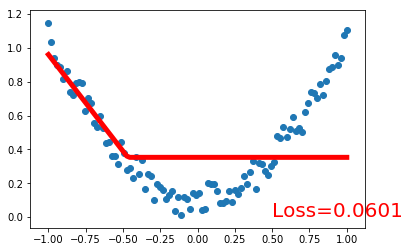

In [19]:
"""
View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
torch: 0.1.11
matplotlib
"""
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting

for t in range(100):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data[0], fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()